In [21]:
import numpy as np
import matplotlib.pyplot as plt
import os, sys, time

%matplotlib notebook

In [2]:
def compute_distance(x,y):
    x = x / np.linalg.norm(x)
    y = y / np.linalg.norm(y)
    return np.linalg.norm(x-y)

In [3]:
def print_percentage(n, t):
    sys.stdout.write('\r')
    sys.stdout.write("[%-20s] %d%%" % ('=' * ((n * 20/t) + 1) , n * 100/t + 1 ))
    sys.stdout.flush()

In [4]:
a = np.load('/fileserver/nmec-handwriting/localfeatures/first-pass/FR-003-004.bin.tif.npy').mean(axis=0)
b = np.load('/fileserver/nmec-handwriting/localfeatures/first-pass/FR-003-007.bin.tif.npy').mean(axis=0)
c = np.load('/fileserver/nmec-handwriting/localfeatures/first-pass/FR-003-008.bin.tif.npy').mean(axis=0)
z = np.load('/fileserver/nmec-handwriting/localfeatures/first-pass/FR-008-004.bin.tif.npy').mean(axis=0)

In [5]:
compute_distance(a,b)

0.12369919202089448

In [6]:
compute_distance(a,c)

0.132800261916276

In [7]:
compute_distance(c,a)

0.132800261916276

In [8]:
compute_distance(a,z)

0.16010213593761907

# Load all features from all files within a directory

In [40]:
feature_dir = '/fileserver/nmec-handwriting/localfeatures/first-pass/'

files = os.listdir(feature_dir)
files.sort()

feature_map = []
for i,filename in enumerate(files):
    path = feature_dir + "/" + filename
    #if os.path.isfile(path) and ( '004.' in filename or '007.' in filename):
    if os.path.isfile(path):
        try:
            feature_map.append( np.load(path).mean(axis=0) )
        except:
            feature_map.append( np.ones([1,4096]) * sys.maxint)
    print_percentage(i, len(files))
        
feature_map = np.array(feature_map)

[====================] 100%

# Start comparing all the files to each other

In [10]:
metric = []
for i, image in enumerate(feature_map):
    metricline = [np.array([compute_distance(image, other) for other in feature_map])]
    metric += metricline
    print_percentage(i, len(feature_map))


metric = np.array(metric)
F = -metric
np.fill_diagonal(F, -sys.maxint)

[====================] 100%

# Calculate the results

In [41]:
soft_correct = 0
hard_correct = 0
total_num = 0

k = 10
g = 8
max_top = 3

for j, i in enumerate(F):
    
    total_num += 1
    topk = i.argsort()[-k:]
    
    if files[j][:6] in (files[index][:6] for index in topk):
        soft_correct += 1
    
    hardsample = list(files[index][3:6] for index in topk[-max_top:])
    if len(set(hardsample)) == 1 and hardsample[0] == files[j][3:6]:
        print "%s matched %s" % (files[j][3:10], hardsample)
        hard_correct += 1

print "%-30s" % ( "-" * 37 )
print "SOFT CRITERIA: Top %d\t= %f" %(k, (soft_correct + 0.0) / total_num)
print "HARD CRITERIA: Top %d\t= %f" %(max_top, (hard_correct + 0.0) / total_num)

026-001 matched ['026', '026', '026']
026-003 matched ['026', '026', '026']
051-005 matched ['051', '051', '051']
056-002 matched ['056', '056', '056']
056-006 matched ['056', '056', '056']
056-007 matched ['056', '056', '056']
060-001 matched ['060', '060', '060']
060-002 matched ['060', '060', '060']
060-003 matched ['060', '060', '060']
060-004 matched ['060', '060', '060']
060-006 matched ['060', '060', '060']
060-007 matched ['060', '060', '060']
060-008 matched ['060', '060', '060']
084-001 matched ['084', '084', '084']
-------------------------------------
SOFT CRITERIA: Top 10	= 0.509887
HARD CRITERIA: Top 3	= 0.019774


<IPython.core.display.Javascript object>


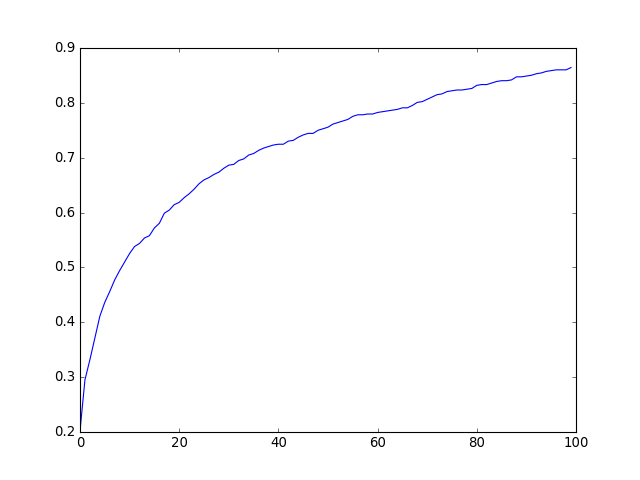

In [44]:
def evaluate(k, matrix):
    n = 0
    for j, i in enumerate(matrix):
        topk = i.argsort()[-k:]

        if files[j][:6] in (files[index][:6] for index in topk):
            n += 1
    return n * 1.0 / len(files)

x = np.array([evaluate(k, F) for k in range(1, 101)], dtype=np.float32)

plt.plot(x)